**Общая информация**

**Срок сдачи:** 20 марта 2019, 06:00  
**Штраф за опоздание:** -1 балл после 06:00 20 марта, -2 балла после 06:00 27 марта, -3 балла после 06:00 3 апреля

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack скинуть ссылку в личный чат @alkhamush
Пример ссылки:
https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb 


Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Значение n_neighbors нужно взять из задания 3. Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -1 балл


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_openml
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
%load_ext pycodestyle_magic

In [48]:
%%pycodestyle

# scipy.stats.mode is used in predict
import scipy
from sklearn.neighbors import KDTree
# pairwise_distance is used with algorithm='metrics_brute'
from sklearn.metrics import pairwise_distances
# LinearLocator is used in visualize_score
from matplotlib.ticker import LinearLocator


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    supported_algorithms = ['kd_tree', 'brute', 'precomp_brute',
                            'metrics_brute']

    def __init__(self, n_neighbors, algorithm='brute'):
        if algorithm not in self.supported_algorithms:
            raise ValueError("unrecognized algorithm: '%s'" % algorithm)

        self.k = n_neighbors
        self.algorithm = algorithm
        self.dist_f = MyKNeighborsClassifier.dist3

    def __repr__(self):
        return ("MyKNeighborsClassifier(algorithm='%s', n_neighbors=%d)"
                % (self.algorithm, self.k))

    @staticmethod
    def conv_labels(y, conv_dict):
        r = np.empty(shape=(len(y)), dtype=np.int32)
        for i, l in enumerate(y):
            r[i] = conv_dict[l]
        return r

    def prepare_labels(self, y):
        if np.issubdtype(type(y), np.number):
            self.labels = np.array(sorted(set(y)))
        else:
            self.labels = np.array(sorted(set(y)), dtype=np.object)
        conv_dict = dict()
        for i, l in enumerate(self.labels):
            conv_dict[l] = i
        self.conv_dict = conv_dict
        self.y = self.conv_labels(y, conv_dict)

    @staticmethod
    def dist2(x, y):
        x = x.reshape(-1, x.shape[-1])
        y = y.reshape(-1, y.shape[-1])
        x2 = (x**2).sum(1)[:, np.newaxis]
        y2 = (y**2).sum(1)[np.newaxis, :]
        xy = np.matmul(x, y.T)
        return x2 - 2*xy + y2

    @staticmethod
    def dist3(x, yd, y2):
        x = x.reshape(-1, x.shape[-1])
        x2 = (x**2).sum(1)[:, np.newaxis]
        xyd = np.matmul(x, yd.T)
        return x2 - xyd + y2

    def kneighbors_brute(self, X):
        dists = self.dist2(X, self.X)
        return dists.argpartition(self.k)[:, :self.k]

    def kneighbors_precomp_brute(self, X):
        dists = self.dist3(X, self.Xd, self.Xs)
        return dists.argpartition(self.k)[:, :self.k]

    def kneighbors_metrics_brute(self, X):
        dists = pairwise_distances(X, self.X)
        return dists.argpartition(self.k)[:, :self.k]

    def kneighbors_kdtree(self, X):
        return self._tree.query(X, self.k, return_distance=False)

    def clear(self):
        if hasattr(self, 'X'):
            del self.X
        if hasattr(self, 'Xd'):
            del self.Xd
        if hasattr(self, 'Xs'):
            del self.Xs
        if hasattr(self, 'labels'):
            del self.labels
        if hasattr(self, 'conv_dict'):
            del self.conv_dict
        if hasattr(self, 'y'):
            del self.y
        if hasattr(self, '_tree'):
            del self._tree

    def fit(self, X, y):
        self.clear()
        self.prepare_labels(y.flatten())
        self.n_classes = len(self.labels)

        if self.algorithm == 'brute':
            self.X = np.asarray(X)
            self.kneigh_f = self.kneighbors_brute
        elif self.algorithm == 'metrics_brute':
            self.X = np.asarray(X)
            self.kneigh_f = self.kneighbors_metrics_brute
        elif self.algorithm == 'precomp_brute':
            Xd = 2*np.asarray(X)
            Xs = np.asarray(X)**2
            self.Xd = Xd.reshape(-1, Xd.shape[-1])
            self.Xs = Xs.reshape(-1, Xs.shape[-1]).sum(1)
            self.kneigh_f = self.kneighbors_precomp_brute
        elif self.algorithm == 'kd_tree':
            self._tree = KDTree(X)
            self.kneigh_f = self.kneighbors_kdtree
        else:
            raise ValueError("Incosistent state of class " + repr(self))

        return self

    def predict(self, X):
        X = np.asarray(X)
        # return indexes of k nearest points
        kneigh = self.kneigh_f(X)
        # convert to labels
        labels = self.y[kneigh]
        # count mode label
        ids = scipy.stats.mode(labels, axis=1).mode.T[0]
        return self.labels[ids]

    def predict_proba(self, X):
        X = np.asarray(X)
        # return indexes of k nearest points
        kneigh = self.kneigh_f(X)
        # convert to labels
        labels = self.y[kneigh]
        cnt = np.apply_along_axis(np.bincount, 1, labels,
                                  minlength=self.n_classes)
        return cnt / self.k

    def score(self, X, y):
        return np.average(self.predict(X) == y)

    def extract_score(self, data, target, N_test, N_k, frac):
        my_score = np.empty((N_test, N_k), dtype=np.float64)
        N_ticks = N_test * N_k
        M_ticks = N_ticks // 10
        L_ticks = N_ticks // 50
        print('Generating score data (%d samples per k):' % N_test)
        for j in range(N_test):
            X1, X2, y1, y2 = train_test_split(data,
                                              target,
                                              test_size=frac,
                                              stratify=target)
            self.fit(X1, y1)
            for i in range(1, 1+N_k):
                t = j*N_k + i-1
                if t % M_ticks == 0:
                    print('|', end='')
                elif t % L_ticks == 0:
                    print('+', end='')

                self.k = i
                my_score[j][i-1] = self.score(X2, y2)

            del X1, X2, y1, y2
        print('#')
        return my_score

    def visualize_score(self, data, target, N_test, N_k, frac):
        my_score = self.extract_score(data, target, N_test, N_k, frac)
        mn = np.mean(my_score, axis=0)
        md = np.median(my_score, axis=0)
        m1 = np.percentile(my_score, 1, axis=0)
        abs_min = int(m1.min()*100)*.01

        fig = plt.figure(figsize=(14, 5))
        ax = fig.add_subplot(1, 1, 1)

        ax.plot(range(1, N_k+1), mn, label='mean', alpha=0.5)
        ax.plot(range(1, N_k+1), md, label='median', alpha=0.8)
        ax.plot(range(1, N_k+1), m1, label='1 percentile', alpha=0.8)
        cax = ax.scatter(range(1, N_k+1), mn, c=mn, cmap=plt.cm.jet)
        fig.colorbar(cax)

        ax.set_xlabel('k neighbors')
        ax.set_xlim(0.5, N_k+.5)
        ax.xaxis.set_ticks(range(1, N_k+1))

        ax.set_ylabel('accuracy')
        ax.set_ylim(abs_min-0.01, 1.01)
        ax.yaxis.set_ticks(np.arange(abs_min, 1.01, 0.01))

        ax.grid()
        ax.legend(loc='center right')

        print('Max mean %.4f with k equal %d' % (mn.max(), mn.argmax()+1))

**IRIS**

In [6]:
iris = datasets.load_iris()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target,
                                                    test_size=0.1,
                                                    stratify=iris.target)

In [8]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 1.77 ms, sys: 948 µs, total: 2.72 ms
Wall time: 4.58 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 775 µs, sys: 0 ns, total: 775 µs
Wall time: 761 µs


MyKNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [11]:
%time clf.predict(X_test)

CPU times: user 5.15 ms, sys: 2.63 ms, total: 7.77 ms
Wall time: 6.12 ms


array([0, 1, 1, 0, 1, 2, 1, 0, 2, 0, 2, 2, 0, 2, 1])

In [12]:
%time my_clf.predict(X_test)

CPU times: user 1.96 ms, sys: 211 µs, total: 2.17 ms
Wall time: 42.5 ms


array([0, 1, 1, 0, 1, 2, 1, 0, 2, 0, 2, 2, 0, 2, 1], dtype=object)

In [13]:
%time clf.predict_proba(X_test)

CPU times: user 1.3 ms, sys: 66 µs, total: 1.37 ms
Wall time: 966 µs


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [14]:
%time my_clf.predict_proba(X_test)

CPU times: user 2.29 ms, sys: 2.61 ms, total: 4.9 ms
Wall time: 3.75 ms


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [15]:
clf.score(X_test, y_test)

1.0

In [16]:
my_clf.score(X_test, y_test)

1.0

###### Задание 3

Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

Generating score data (100001 samples per k):
|+++++|+++++|+++++|+++++|+++++|+++++|+++++|+++++|+++++|+++++#
Max mean 0.9744 with k equal 17


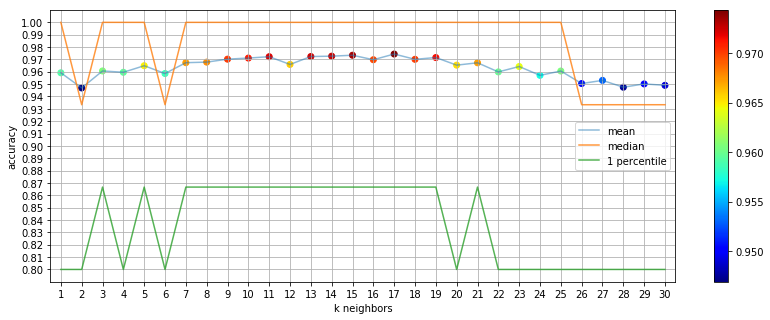

In [50]:
score_clf = MyKNeighborsClassifier(n_neighbors=1)
score_clf.visualize_score(data=iris.data,
                       target=iris.target, 
                       N_test=100001,
                       N_k=30,
                       frac=0.1)

**MNIST**

In [19]:
#mnist = fetch_mldata('MNIST original')
mnist = fetch_openml('mnist_784')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data,
                                                    mnist.target,
                                                    test_size=0.01,
                                                    stratify=mnist.target)

In [21]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [22]:
%time clf.fit(X_train, y_train)

CPU times: user 42.6 s, sys: 88.2 ms, total: 42.7 s
Wall time: 42.9 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [23]:
%time my_clf.fit(X_train, y_train)

CPU times: user 14.3 ms, sys: 1 µs, total: 14.3 ms
Wall time: 13.8 ms


MyKNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [24]:
%time clf.predict(X_test)

CPU times: user 1min 22s, sys: 21.3 ms, total: 1min 22s
Wall time: 1min 22s


array(['7', '9', '5', '6', '9', '5', '3', '1', '0', '1', '1', '6', '8',
       '1', '1', '1', '4', '8', '0', '0', '1', '8', '5', '7', '1', '1',
       '8', '3', '4', '5', '7', '9', '1', '2', '0', '8', '6', '9', '7',
       '0', '8', '1', '8', '0', '1', '7', '2', '3', '1', '1', '1', '8',
       '5', '1', '0', '4', '4', '1', '7', '1', '9', '2', '2', '2', '4',
       '6', '3', '3', '8', '8', '3', '5', '4', '4', '7', '2', '3', '9',
       '0', '9', '0', '8', '8', '8', '0', '1', '7', '8', '1', '8', '0',
       '5', '9', '3', '8', '6', '6', '0', '6', '4', '0', '9', '2', '6',
       '6', '2', '0', '2', '2', '2', '3', '2', '1', '7', '5', '8', '8',
       '3', '3', '2', '1', '1', '3', '8', '3', '4', '5', '1', '0', '9',
       '8', '9', '3', '1', '4', '4', '2', '8', '7', '9', '9', '3', '2',
       '0', '2', '6', '6', '6', '9', '1', '7', '7', '2', '6', '4', '0',
       '7', '9', '0', '6', '6', '6', '0', '9', '0', '0', '2', '6', '5',
       '9', '5', '0', '6', '8', '0', '2', '8', '0', '0', '3', '6

In [25]:
%time my_clf.predict(X_test)

CPU times: user 5.46 s, sys: 1.02 s, total: 6.48 s
Wall time: 2.55 s


array(['7', '9', '5', '6', '9', '5', '3', '1', '0', '1', '1', '6', '8',
       '1', '1', '1', '4', '8', '0', '0', '1', '8', '5', '7', '1', '1',
       '8', '3', '4', '5', '7', '9', '1', '2', '0', '8', '6', '9', '7',
       '0', '8', '1', '8', '0', '1', '7', '2', '3', '1', '1', '1', '8',
       '5', '1', '0', '4', '4', '1', '7', '1', '9', '2', '2', '2', '4',
       '6', '3', '3', '8', '8', '3', '5', '4', '4', '7', '2', '3', '9',
       '0', '9', '0', '8', '8', '8', '0', '1', '7', '8', '1', '8', '0',
       '5', '9', '3', '8', '6', '6', '0', '6', '4', '0', '9', '2', '6',
       '6', '2', '0', '2', '2', '2', '3', '2', '1', '7', '5', '8', '8',
       '3', '3', '2', '1', '1', '3', '8', '3', '4', '5', '1', '0', '9',
       '8', '9', '3', '1', '4', '4', '2', '8', '7', '9', '9', '3', '2',
       '0', '2', '6', '6', '6', '9', '1', '7', '7', '2', '6', '4', '0',
       '7', '9', '0', '6', '6', '6', '0', '9', '0', '0', '2', '6', '5',
       '9', '5', '0', '6', '8', '0', '2', '8', '0', '0', '3', '6

In [26]:
%time clf.predict_proba(X_test)

CPU times: user 1min 21s, sys: 9.13 ms, total: 1min 21s
Wall time: 1min 21s


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
%time my_clf.predict_proba(X_test)

CPU times: user 5.43 s, sys: 986 ms, total: 6.41 s
Wall time: 2.54 s


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
clf.score(X_test, y_test)

0.9728571428571429

In [29]:
my_clf.score(X_test, y_test)

0.9728571428571429

##### Задание 4

In [30]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data,
                                                    mnist.target,
                                                    test_size=0.01,
                                                    stratify=mnist.target)

In [32]:
%time clf.fit(X_train, y_train)

CPU times: user 43.4 s, sys: 112 ms, total: 43.5 s
Wall time: 43.8 s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [33]:
%time my_clf.fit(X_train, y_train)

CPU times: user 42.2 s, sys: 168 ms, total: 42.3 s
Wall time: 42.4 s


MyKNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [34]:
%time clf.predict(X_test)

CPU times: user 1min 22s, sys: 17.5 ms, total: 1min 22s
Wall time: 1min 22s


array(['1', '3', '8', '7', '4', '1', '1', '0', '3', '9', '2', '5', '7',
       '1', '5', '2', '7', '3', '8', '3', '8', '3', '1', '3', '8', '4',
       '4', '8', '3', '5', '4', '6', '0', '9', '3', '7', '0', '8', '9',
       '6', '3', '0', '1', '5', '6', '0', '0', '6', '9', '0', '1', '9',
       '1', '6', '5', '1', '5', '4', '1', '6', '8', '6', '9', '7', '7',
       '9', '5', '8', '9', '0', '2', '6', '7', '8', '7', '4', '5', '3',
       '6', '3', '0', '0', '8', '9', '7', '7', '9', '1', '2', '2', '5',
       '1', '7', '8', '4', '7', '3', '7', '0', '5', '2', '7', '5', '7',
       '6', '4', '4', '9', '8', '6', '1', '9', '4', '9', '3', '2', '5',
       '0', '1', '2', '0', '9', '7', '3', '7', '6', '7', '0', '5', '4',
       '1', '1', '0', '9', '6', '7', '6', '1', '7', '5', '1', '3', '6',
       '8', '0', '3', '6', '2', '4', '7', '7', '8', '8', '6', '7', '5',
       '8', '2', '3', '5', '3', '0', '2', '5', '3', '0', '5', '5', '2',
       '3', '4', '5', '1', '8', '5', '4', '1', '1', '2', '5', '0

In [35]:
%time my_clf.predict(X_test)

CPU times: user 1min 10s, sys: 994 µs, total: 1min 10s
Wall time: 1min 10s


array(['1', '3', '8', '7', '4', '1', '1', '0', '3', '9', '2', '5', '7',
       '1', '5', '2', '7', '3', '8', '3', '8', '3', '1', '3', '8', '4',
       '4', '8', '3', '5', '4', '6', '0', '9', '3', '7', '0', '8', '9',
       '6', '3', '0', '1', '5', '6', '0', '0', '6', '9', '0', '1', '9',
       '1', '6', '5', '1', '5', '4', '1', '6', '8', '6', '9', '7', '7',
       '9', '5', '8', '9', '0', '2', '6', '7', '8', '7', '4', '5', '3',
       '6', '3', '0', '0', '8', '9', '7', '7', '9', '1', '2', '2', '5',
       '1', '7', '8', '4', '7', '3', '7', '0', '5', '2', '7', '5', '7',
       '6', '4', '4', '9', '8', '6', '1', '9', '4', '9', '3', '2', '5',
       '0', '1', '2', '0', '9', '7', '3', '7', '6', '7', '0', '5', '4',
       '1', '1', '0', '9', '6', '7', '6', '1', '7', '5', '1', '3', '6',
       '8', '0', '3', '6', '2', '4', '7', '7', '8', '8', '6', '7', '5',
       '8', '2', '3', '5', '3', '0', '2', '5', '3', '0', '5', '5', '2',
       '3', '4', '5', '1', '8', '5', '4', '1', '1', '2', '5', '0

In [36]:
%time clf.predict_proba(X_test)

CPU times: user 1min 21s, sys: 2.01 ms, total: 1min 21s
Wall time: 1min 21s


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [37]:
%time my_clf.predict_proba(X_test)

CPU times: user 1min 9s, sys: 3.98 ms, total: 1min 9s
Wall time: 1min 9s


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [38]:
clf.score(X_test, y_test)

0.9585714285714285

In [39]:
my_clf.score(X_test, y_test)

0.9585714285714285

##### Задание 5

In [83]:
# seaborn
#   библиотека визуализации данных, хранимых в pandas.DataFrame
#   является оберткой над matplotlib
# matplotlib
#   библиотека для 2D-визуализации (т.е. результат - изображение) в Python.
#   поддерживает разные типы отображения. можно использовать для визуального
#   анализа данных
# train_test_split
#   функция для разделения данных на обучающую и тестовую выборки
# Pipeline  (from sklearn.pipeline import Pipeline)
#   класс, позволяющий объединить несколько последовательных преобразований
#   в один объект, с возможностью изменения параметров каждого шага.
#   можно использовать для кросс-валидации последовательности преобразований
#   на наборах параметров
# %load_ext
#   line magic команда, предоставленная ядром IPython, для загрузки его модулей
# StandardScaler (from sklearn.preprocessing import StandardScaler)
#   класс для приведения данных к нулевому среднему и идиничному стандартному
#   отклонению. выполняется для каждой компоненты по отдельности
# ClassifierMixin
#   класс, реализующий метод score с использованием метода predict
# NeighborsBase
#   класс, реализующий внутренние/приватные методы инициализации
# KNeighborsMixin
#   класс-обертка над методами поиска ближайших соседей
# SupervisedIntegerMixin
#   класс, реализующий метод fit как обертку над предоставляемым методом _fit,
#   дополнительно проверяя X и y

## Just for fun

- Дополнительные замеры производительности командой `timeit`.
- Измерение _score_ для разных параметров *k* на датасете _mnist_.

### KDTree

Измерение времени работы `KNeighborsClassifier` и `MyKNeighborsClassifier` с использованием структуры `KDTree`. Измерения производятся в порядке "библиотечная реализация, моя реализация".

### mnist_784

In [40]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data,
                                                    mnist.target,
                                                    test_size=0.01,
                                                    stratify=mnist.target)

sk_kd_clf = KNeighborsClassifier(n_neighbors=4, algorithm='kd_tree')
my_kd_clf = MyKNeighborsClassifier(n_neighbors=4, algorithm='kd_tree')

print('#### fit')
%timeit sk_kd_clf.fit(X_train, y_train)
%timeit my_kd_clf.fit(X_train, y_train)

print('#### predict')
%timeit sk_kd_clf.predict(X_test)
%timeit my_kd_clf.predict(X_test)

print('#### predict_proba')
%timeit sk_kd_clf.predict_proba(X_test)
%timeit my_kd_clf.predict_proba(X_test)

print('#### score')
%timeit sk_kd_clf.score(X_test, y_test)
%timeit my_kd_clf.score(X_test, y_test)

#### fit
42.1 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
41.9 s ± 326 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#### predict
1min 21s ± 620 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 8s ± 250 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#### predict_proba
1min 22s ± 883 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 8s ± 176 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#### score
1min 21s ± 61.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 8s ± 58.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Brute

Измерение времени работы `KNeighborsClassifier` и `MyKNeighborsClassifier` с использованием попарного сравнения расстояний. Измерения производятся командой `timeit` в порядке "библиотечная реализация, мои реализация".

Мои наивные реализации:
* `'brute'` - сохраняет матрица векторов `np.asarray(X_train)`, используется по умолчанию;
* `'precomp_brute'` - вместо исходной матрицы используются `2*X_train` и `np.einsum('ij,ij->i', X_train, X_train)`;
* `'metrics_brute'` - аналогично `'brute'`, но расстояния вычисляются функцией `sklearn.metrics.pairwise_distances`.

### mnist_784

In [52]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data,
                                                    mnist.target,
                                                    test_size=0.01,
                                                    stratify=mnist.target)

sk_br_clf = KNeighborsClassifier(n_neighbors=4, algorithm='brute')
my_br_clf = MyKNeighborsClassifier(n_neighbors=4)
my_pb_clf = MyKNeighborsClassifier(n_neighbors=4, algorithm='precomp_brute')
my_mb_clf = MyKNeighborsClassifier(n_neighbors=4, algorithm='metrics_brute')

print('#### fit')
%timeit sk_br_clf.fit(X_train, y_train)
%timeit my_br_clf.fit(X_train, y_train)
%timeit my_pb_clf.fit(X_train, y_train)
%timeit my_mb_clf.fit(X_train, y_train)

print('#### predict')
%timeit sk_br_clf.predict(X_test)
%timeit my_br_clf.predict(X_test)
%timeit my_pb_clf.predict(X_test)
%timeit my_mb_clf.predict(X_test)
print('#### predict_proba')
%timeit sk_br_clf.predict_proba(X_test)
%timeit my_br_clf.predict_proba(X_test)
%timeit my_pb_clf.predict_proba(X_test)
%timeit my_mb_clf.predict_proba(X_test)
print('#### score')
%timeit sk_br_clf.score(X_test, y_test)
%timeit my_br_clf.score(X_test, y_test)
%timeit my_pb_clf.score(X_test, y_test)
%timeit my_mb_clf.score(X_test, y_test)

#### fit
117 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.7 ms ± 417 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
411 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.7 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
#### predict
2.25 s ± 9.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.78 s ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.4 s ± 9.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.32 s ± 36.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#### predict_proba
2.24 s ± 8.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.77 s ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.4 s ± 5.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.31 s ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#### score
2.27 s ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.8 s ± 52.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop

### iris

In [42]:
X_train, X_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target,
                                                    test_size=0.1,
                                                    stratify=iris.target)

sk_br_clf = KNeighborsClassifier(n_neighbors=17, algorithm='brute')
my_br_clf = MyKNeighborsClassifier(n_neighbors=17)
my_pb_clf = MyKNeighborsClassifier(n_neighbors=17, algorithm='precomp_brute')
my_mb_clf = MyKNeighborsClassifier(n_neighbors=17, algorithm='metrics_brute')

print('#### fit')
%timeit sk_br_clf.fit(X_train, y_train)
%timeit my_br_clf.fit(X_train, y_train)
%timeit my_pb_clf.fit(X_train, y_train)
%timeit my_mb_clf.fit(X_train, y_train)

print('#### predict')
%timeit sk_br_clf.predict(X_test)
%timeit my_br_clf.predict(X_test)
%timeit my_pb_clf.predict(X_test)
%timeit my_mb_clf.predict(X_test)

print('#### predict_proba')
%timeit sk_br_clf.predict_proba(X_test)
%timeit my_br_clf.predict_proba(X_test)
%timeit my_pb_clf.predict_proba(X_test)
%timeit my_mb_clf.predict_proba(X_test)

print('#### score')
%timeit sk_br_clf.score(X_test, y_test)
%timeit my_br_clf.score(X_test, y_test)
%timeit my_pb_clf.score(X_test, y_test)
%timeit my_mb_clf.score(X_test, y_test)

#### fit
172 µs ± 796 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
64.4 µs ± 2.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
74.1 µs ± 349 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
62.2 µs ± 3.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
#### predict
456 µs ± 2.28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
164 µs ± 2.76 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
148 µs ± 204 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
275 µs ± 1.71 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#### predict_proba
428 µs ± 4.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
163 µs ± 321 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
150 µs ± 258 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
271 µs ± 1.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#### score
586 µs ± 2.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
191 µs 

### Визуализация для датасета mnist_784

Для измерения статистики _score_ от *k* используется алгоритм `metrics_brute` как самый быстрый.

Generating score data (101 samples per k):
|+++++|+++++|+++++|+++++|+++++|+++++|+++++|+++++|+++++|+++++#
Max mean 0.9743 with k equal 3


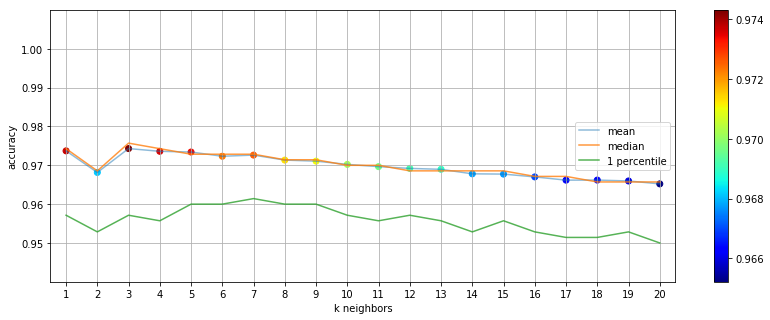

In [53]:
score_clf = MyKNeighborsClassifier(n_neighbors=1, algorithm='metrics_brute')
score_clf.visualize_score(data=mnist.data,
                          target=mnist.target, 
                          N_test=101,
                          N_k=20,
                          frac=0.01)